## Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from matplotlib import pyplot as plt

from functools import reduce
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from keras import Model
from pprint import pprint

import time

tf.random.set_seed(42)

# Tensor and Operators 

## Tensors
1. A Tensor is a suitable choice if you are going to use GPU. A tensor can reside in accelerator’s memory.
2. Tensors are immutable. You always create new one.

TensorFlow offers a rich library of operations (tf.add, tf.matmul, tf.linalg.inv etc.) that consume and produce tf.Tensors. These operations automatically convert native Python types, for example:

In [5]:
"""Tensors are constant operations.
"""
scalar = tf.constant(1, dtype=tf.uint8)
vector = tf.constant([1, 2, 3, 4], dtype=tf.float32)
matrix = tf.constant(np.array([[1, 2], [3, 4]]), dtype=tf.float32) #must set as np.array.

pprint([scalar, vector, matrix])
print('\n-------------\n')

"""Special tensors.
"""
# Create zero tensor with given shape.
zeros = tf.zeros((2, 2))
# Create tensor with random values from [0,1] with given shape.
norm = tf.random.uniform((3, 2))
# Create unit tensor.
unit = tf.ones_like((2, 2))


pprint([zeros, norm, unit])

[<tf.Tensor: shape=(), dtype=uint8, numpy=1>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>]

-------------

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.68789124, 0.48447883],
       [0.9309944 , 0.252187  ],
       [0.73115396, 0.89256823]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1])>]


In [3]:
"""Get shape.
"""
print(matrix.shape)
pprint(tf.shape(matrix))
print(id(matrix), end = '\n-------------\n')

""" We can only use the tf.cast operation to create a new tensor with the desired new data type.
"""
matrix = tf.cast(matrix, tf.uint8)
print(matrix)

(2, 2)
<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 2])>
2387470106288
-------------
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8)


## Operations

In [4]:
"""Operations.
"""
a = tf.add(1, 2)
b = tf.add([1, 2], [7, 0])
c = tf.square(5)
d = tf.reduce_sum([1, 2, 3])
e = tf.square(2) + tf.square(3)

print('Value :', K.eval(e))

Value : 13


In [5]:
x = tf.matmul([[1]], [[2, 3]])

print('Shape:', x.shape)
print('Type:', x.dtype)
print('Value :', K.eval(x))

Shape: (1, 2)
Type: <dtype: 'int32'>
Value : [[2 3]]


## Numpy compatibility

In [4]:
np_arr = np.ones((3, 3))

print("TensorFlow operations convert numpy arrays to Tensors automatically")
# Multiply np_arr with scalar 42 and convert to tf.
tensor = tf.multiply(np_arr, 42)
print(tensor, end='\n')
print('Value : \n', K.eval(tensor), end='\n-------------------\n')

print("And NumPy operations convert Tensors to numpy arrays automatically")
print(np.add(tensor, 1), end='\n')
print('Value : \n', K.eval(np.add(tensor, 1)), end='\n-------------------\n')

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
Value : 
 [[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]
-------------------
And NumPy operations convert Tensors to numpy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
Value : 
 [[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
-------------------


## GPU acceleration
Many TensorFlow operations are accelerated using the GPU for computation. Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation—copying the tensor between CPU and GPU memory, if necessary.

In [5]:
x = tf.random.uniform([3, 3])
print('Value : \n', K.eval(x))

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Value : 
 [[0.5582588  0.21942294 0.2266742 ]
 [0.43406606 0.86381006 0.4517902 ]
 [0.8892014  0.17752266 0.6253607 ]]
Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True


## Explicit Device Placement

In [46]:
import time

def time_matmul(x):
    start = time.time()
    for loop in range(10):
        tf.matmul(x, x)
    res = time.time() - start
    
    print("10 loops: {:0.2f}ms".format(1000*res))
    
    
# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)
    
# Force execution on GPU #0 if available
if tf.config.list_physical_devices("GPU"):
    print('On GPU:')
    with tf.device("GPU:0"):
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

On CPU:
10 loops: 123.00ms
On GPU:
10 loops: 13.00ms


## Linear regression
With GD optimizer

In [2]:
# ground truth
true_weights = tf.constant([1,2,3,40,5], dtype=tf.float32)[:, tf.newaxis]
true_bias = tf.constant([12], dtype=tf.float32)

"""Create DATA,...: use tf.constant
   Create Weights, biases: use tf.Variable
"""

# some random training data
x = tf.constant(tf.random.uniform((32, 5)), dtype=tf.float32)
y = tf.constant(x @ true_weights + true_bias, dtype=tf.float32)

# model parameters
weights = tf.Variable(tf.random.uniform((5, 1)), tf.float32)
bias = tf.Variable(tf.random.uniform((1, 1)), tf.float32)

In [3]:
epochs = 2201
learning_rate = 1e-2

for epoch in range(epochs):
    with tf.GradientTape(persistent=True) as tape:
        y_ = tf.linalg.matmul(x, weights) + bias
        loss = tf.reduce_mean(tf.square(y - y_))
    
    if not (epoch % 200):
        print('mean squared loss at iteration {:4d} is {:5.4f}'.format(epoch, loss))
    
    # calculate Gradient
    grad_w = tape.gradient(loss, weights)    
    grad_b = tape.gradient(loss, bias)
    
    weights.assign_add(-1 * learning_rate * grad_w) # assign: = ; assign_add: +=
    bias.assign_add(-1 * learning_rate * grad_b)
    
print('\nRESULT', end='\n')
print('Predicted weights: ', weights.numpy(), end='\n\n')
print('Predicted bias: ', bias.numpy())
print('\n-------\n')
print('True weigthts: ', true_weights.numpy(), end='\n\n')
print('True bias: ', true_bias.numpy())

mean squared loss at iteration    0 is 1523.9578
mean squared loss at iteration  200 is 47.8916
mean squared loss at iteration  400 is 21.6080
mean squared loss at iteration  600 is 10.1577
mean squared loss at iteration  800 is 5.0559
mean squared loss at iteration 1000 is 2.7078
mean squared loss at iteration 1200 is 1.5770
mean squared loss at iteration 1400 is 0.9988
mean squared loss at iteration 1600 is 0.6811
mean squared loss at iteration 1800 is 0.4924
mean squared loss at iteration 2000 is 0.3718
mean squared loss at iteration 2200 is 0.2897

RESULT
Predicted weights:  [[ 1.1797919]
 [-0.1583631]
 [ 2.239581 ]
 [38.297863 ]
 [ 5.47278  ]]

Predicted bias:  [[14.064942]]

-------

True weigthts:  [[ 1.]
 [ 2.]
 [ 3.]
 [40.]
 [ 5.]]

True bias:  [12.]


# Layers, activations, models
## Build and train simple linear regression model

In [4]:
class LinearRegression(tf.keras.Model):
    def __init__(self, num_params, **kwargs):
        super().__init__(**kwargs)
        self._weights = tf.Variable(tf.random.uniform((num_params, 1)), dtype=tf.float32)
        self._bias = tf.Variable(tf.random.uniform((1, 1)), dtype=tf.float32)
        self.model = None
    
    @tf.function
    def call(self, x):
        """Note that we decorated the __call__ method with tf.function , hence a graph will
        be generated to back up the computation."""
        return tf.linalg.matmul(x, self._weights) + self._bias
    
    @property
    def variants(self):
        return self._weights, self._bias
    
    @tf.function
    def training_step(self, x, learning_rate):
        with tf.GradientTape(persistent=True) as tp:
            y_ = self.call(x)
            loss = tf.reduce_mean(tf.square(y - y_))
        grad_w = tp.gradient(loss, self._weights)    
        grad_b = tp.gradient(loss, self._bias)
        
        self._weights.assign_add(tf.constant([-1 * learning_rate], tf.float32) * grad_w)
        self._bias.assign_add(tf.constant([-1 * learning_rate], tf.float32) * grad_b)
        
        return loss
    
    @tf.function
    def fit(self, x, epochs, learning_rate):
        begin = time.time()
        loss_hist = list()
        for ep in range(epochs):
            loss = self.training_step(x, learning_rate)           
            if not (ep%200):
                loss_hist.append(loss)
            
        print('Training time: {} seconds'.format(time.time()-begin))
        return loss_hist

In [5]:
model = LinearRegression(5)
model.build(x.shape)
model.summary()

Model: "linear_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(x, 2201, 1e-2)

Training time: 3.6450350284576416 seconds


In [7]:
weights, bias = model.variants
print('\nRESULT', end='\n')
print('Predicted weights: ', weights.numpy(), end='\n\n')
print('Predicted bias: ', bias.numpy())
print('\n-------\n')
print('True weigthts: ', true_weights.numpy(), end='\n\n')
print('True bias: ', true_bias.numpy())


RESULT
Predicted weights:  [[ 1.1496135]
 [-0.1800218]
 [ 2.2054672]
 [38.27897  ]
 [ 5.431044 ]]

Predicted bias:  [[14.141143]]

-------

True weigthts:  [[ 1.]
 [ 2.]
 [ 3.]
 [40.]
 [ 5.]]

True bias:  [12.]


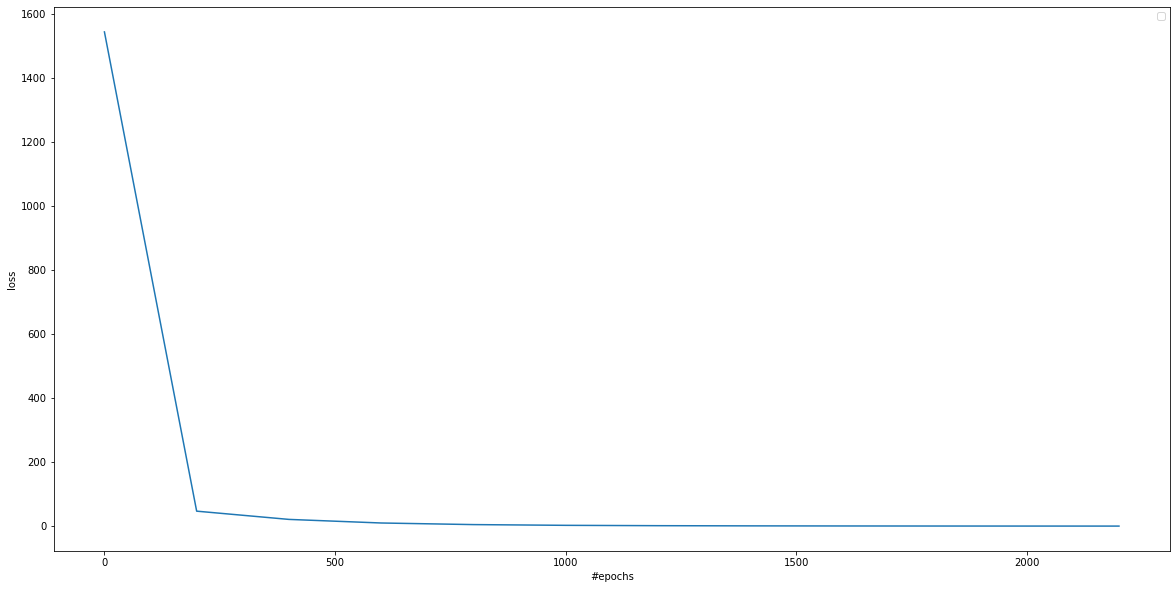

In [8]:
history_np = [X.numpy() for X in history]
epoch = np.arange(0, 2201, 200)

plt.rcParams["figure.figsize"] = (20,10)

plt.xlabel('#epochs')
plt.ylabel('loss')
plt.legend(['loss'])
plt.plot(epoch, history_np)
plt.show()

## Build simple linear layers
One problem with this linear layer is that it needs the complete sizing information and allocates resources for all the variables upfront. Ideally, we want it to be a bit lazy, it should calculate variable sizes and occupy resources only when needed. To archive this, we implement the *build* method which will handle the variable initialization.

In [68]:
"""The linear regression model is constructed w/o 'build' method.
"""
class Linear(tf.keras.layers.Layer):
    def __init__(self, num_in, num_out, **kwargs):
        super().__init__(**kwargs)
        self._weights = tf.Variable(tf.random.uniform((num_in, num_out)), tf.float32)
        self._bias = tf.Variable(tf.random.uniform((1, num_out)), tf.float32)
        
    @tf.function
    def call(self, x):
        return tf.linalg.matmul(x, self._weights) + self._bias

    
class Regression(tf.keras.Model):
    def __init__(self, num_in_per_layer, num_out_per_layer, **kwargs):
        super().__init__(**kwargs)
        self._layers = [Linear(num_in, num_out) for (num_in, num_out) in zip(num_in_per_layer, num_out_per_layer)]
    
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
            return x

In [70]:
model = Regression([5, 3], [3, 1])
model.build(x.shape)
model.variables

[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
 array([[0.1795603 , 0.9078413 , 0.74117076],
        [0.6874347 , 0.755996  , 0.450325  ],
        [0.6559037 , 0.03319371, 0.4574138 ],
        [0.6045933 , 0.7853018 , 0.96527755],
        [0.40443385, 0.7059109 , 0.46173537]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[0.7761378, 0.6829244, 0.6924006]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
 array([[0.6195084 ],
        [0.76292896],
        [0.20563734]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.2539693]], dtype=float32)>]

In [3]:
"""The linear regression model is constructed with 'build' method.
"""
class Linear(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self._weights = self.add_weight(shape=(input_shape[-1], self.units), # Shortcut to create weights.
                                   initializer='random_normal',
                                   trainable = True)
        self._bias = self.add_weight(shape=(self.units,),
                                initializer='random_normal',
                                trainable = True)
        super().build(input_shape)
    
    @tf.function
    def call(self, x):
        return tf.linalg.matmul(x, self._weights) + self._bias
    
    
class Regression(tf.keras.Model):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self._layers = [Linear(unit) for unit in units]
        
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

In [28]:
model = Regression([5, 1])
model.build(x.shape)
model.summary()

Model: "regression_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_2 (Linear)            multiple                  30        
_________________________________________________________________
linear_3 (Linear)            multiple                  6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [3]:
"""Define train fuction for Linear Regression layers.
"""
"""CONFIG"""
learning_rate = 1e-2
epochs = 2201

@tf.function
def training_step(model):
    with tf.GradientTape(persistent=True) as tp:
        y_ = model(x)
        loss = tf.reduce_mean(tf.square(y - y_))
    grads = tp.gradient(loss, model.variables)
    
    for grad, var in zip(grads, model.variables):
        var.assign_add(tf.constant([-1*learning_rate], tf.float32) * grad)
        
    return loss

In [5]:
for epoch in range(epochs):
    loss = training_step(model)
    
print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())
pprint(model.variables)

Mean absolute error is:  0.0025976896


## Adding activation
So our newest model is a composition of two linear transformation, but the composition of two linear transformations is just another linear transformation. That's lead model still stupid although it has many layers.

Since activation functions usually follows immediately after linear transformations, we can fuse them together, so that the model code can be simpler.

In [4]:
class LinearwActivation(tf.keras.layers.Layer):
    def __init__(self, units, activ = None, **kwargs):
        super(LinearwActivation, self).__init__(**kwargs)
        self.units = units
        self.activ = activ
    
    def build(self, input_shape):
        self._weights = self.add_weight(shape=(input_shape[-1], self.units),
                                   initializer='random_normal',
                                   trainable = True)
        self._bias = self.add_weight(shape=(self.units,),
                                initializer='random_normal',
                                trainable = True)
        super().build(input_shape)
        
    @tf.function
    def call(self, x):
        output = tf.linalg.matmul(x, self._weights) + self._bias
        if self.activ == 'relu':
            output = tf.maximum(tf.constant(0, tf.float32), output)
        elif self.activ == 'sigmoid':
            output = tf.math.sigmoid(output)
        return output
            

class NeuralNet(tf.keras.Model):
    def __init__(self, units, last_linear=True, **kwargs):
        super().__init__(**kwargs)
        layers = [LinearwActivation(unit, activ='relu') for unit in units[:-1]] # Add relu activation except last layer
        layers.append(LinearwActivation(units[-1], activ='linear' if last_linear else 'relu'))
        self._layers = layers
    
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x      

In [5]:
model = NeuralNet([3,1])

for epoch in range(epochs):
    loss = training_step(model)
    
print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())
pprint(model.variables)

Mean absolute error is:  0.002593279
[<tf.Variable 'linearw_activation/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.17073853,  0.12671891,  0.01699875],
       [ 0.24188042,  0.34807658, -0.07004322],
       [ 0.4161529 ,  0.47135684, -0.04794532],
       [ 5.789427  ,  6.054765  , -0.01543931],
       [ 0.71725917,  0.76302993,  0.05314527]], dtype=float32)>,
 <tf.Variable 'linearw_activation/Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.5186415 ,  0.5185951 , -0.03705135], dtype=float32)>,
 <tf.Variable 'linearw_activation_1/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.2908049 ],
       [3.460086  ],
       [0.06414887]], dtype=float32)>,
 <tf.Variable 'linearw_activation_1/Variable:0' shape=(1,) dtype=float32, numpy=array([8.499622], dtype=float32)>]


# Fully connected layer

With the code above, we just made a fully connected network, or historically called multi
layer perceptron(with out any actual perceptron) as well as feed forward neural network.
Its essentially a sequence of linear transformation with in-place non-linear activations
sandwiched in between. We usually think of the initial layers as feature extractors that is
performing some kind on implicit feature engineering and selection, and think of the last
layer as a regressor or classifier per task.

In [2]:
class Sequential(tf.keras.Model):
    def __init__(self, layers, **kwargs):
        super().__init__(**kwargs)
        self._layers = layers
    
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

class FCN(tf.keras.Model):
    def __init__(self, num_hidds, num_targets, hidd_activ='relu', **kwargs):
        super().__init__(**kwargs)
        if type(num_hidds) is int:
            num_hidds = [num_hidds]
        self.hidd_layers = Sequential([tf.keras.layers.Dense(unit, activation=hidd_activ) for unit in num_hidds]) 
        self.last_layer = tf.keras.layers.Dense(num_targets, activation='linear')
        
    @tf.function 
    def call(self, x):
        features = self.hidd_layers(x)
        output = self.last_layer(features)
        return output

In [3]:
"""Toy example from Boston housing dataset.
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

y_train, y_test = map(lambda x: np.expand_dims(x, -1), (y_train, y_test))
x_train, y_train, x_test, y_test = map(lambda x: tf.cast(x, tf.float32), (x_train, y_train, x_test, y_test))

In [4]:
@tf.function 
def training_step(model, x_train, y_train, learning_rate):
    with tf.GradientTape(persistent=True) as tp:
        y_ = model(x_train)
        loss = tf.reduce_mean(tf.square(y_train - y_))
    grads = tp.gradient(loss, model.variables)
    for grad, var in zip(grads, model.variables):
        var.assign_add(tf.constant([-1*learning_rate], tf.float32) * grad)
    return loss

@tf.function
def testing_step(model, x_test, y_test):
    return tf.reduce_mean(tf.square(y_test - model(x_test)))      

In [5]:
def train(model, epochs, learning_rate):
    his = []
    for epoch in range(1, epochs+1):
        train_loss = training_step(model, x_train, y_train, learning_rate)
        test_loss = testing_step(model, x_test, y_test)
        if not(epoch%200):
            his.append({'epoch': epoch,
                        'train_loss': train_loss.numpy(),
                        'test_loss': test_loss.numpy()
            })
            print('Epoch {} has mean squeared loss {}.'.format(epoch, train_loss))
    return model, pd.DataFrame(his)

model = FCN(4, 1)
model, model_his = train(model, 2000, 1e-3)    

Epoch 200 has mean squeared loss 15790.5322265625.
Epoch 400 has mean squeared loss 7136.1015625.
Epoch 600 has mean squeared loss 3250.5244140625.
Epoch 800 has mean squeared loss 1506.0128173828125.
Epoch 1000 has mean squeared loss 722.7835083007812.
Epoch 1200 has mean squeared loss 371.1363830566406.
Epoch 1400 has mean squeared loss 213.25872802734375.
Epoch 1600 has mean squeared loss 142.37594604492188.
Epoch 1800 has mean squeared loss 110.55196380615234.
Epoch 2000 has mean squeared loss 96.26395416259766.


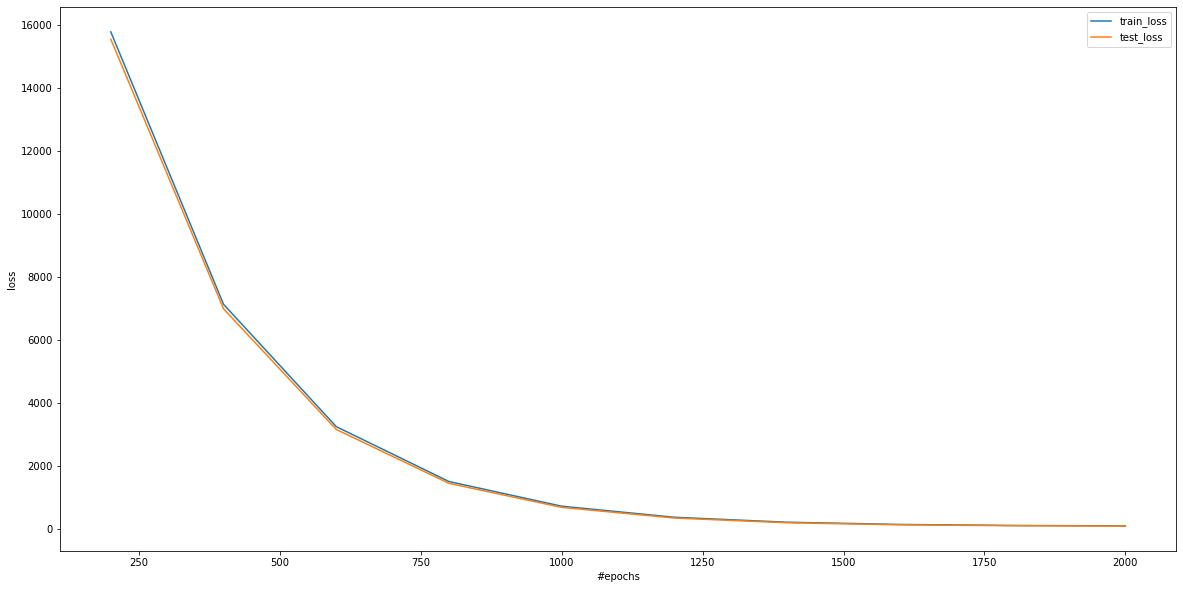

In [6]:
"""PLOT loss reduction during training.
"""
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(model_his.epoch, model_his.train_loss)
plt.plot(model_his.epoch, model_his.test_loss)
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.show()

With normal gradient descent algorithm, we need almost 2000 epochs to archive a good result. 

# Optimization
## Stochastic gradient descent

In [4]:
"""First, we must create dataset object. 
"""
class Dataset(object):
    def __init__(self, tensors, batch_size, shuffle=True):
        # isinstance for check the tensors wheter it is tuple of list
        self.tensors = tensors if isinstance(tensors, (tuple, list)) else (tensors, )      
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.total = tensors[0].shape[0] # Check total data units
        
        # assert + condition, if condition is not true -> raise error
        assert all(self.total == tensor.shape[0] for tensor in self.tensors), 'Tensors should have matched length!'
        
        self.n_steps = self.total // self.batch_size
        self._indices = tf.range(self.total) #index of dataset
        
    # Function __iter__ for getting iterators of data tensors
    def  __iter__(self):
        self._i = 0 #shuffle counter
        if self.shuffle:
            self._indices = tf.random.shuffle(self._indices)
        return self
    
    # Get data from iterators.
    def __next__(self):
        if self._i >= self.n_steps:
            raise StopIteration
        else:
            start = self._i * self.batch_size
            end = start + self.batch_size
            indices = self._indices[start: end]
            samples = (tf.gather(tensor, indices) for tensor in self.tensors)
            self._i += 1
            return samples    

In [5]:
train_ds = Dataset((x_train, y_train), batch_size=32)
test_ds = Dataset((x_test, y_test), batch_size=32)

In [6]:
def train(model, epochs, learning_rate):
    his = []
    for epoch in range(1, epochs+1):
        train_loss = []
        for x, y in train_ds:
            train_loss.append(training_step(model, x, y, learning_rate).numpy())
        test_loss_batch = []
        for x, y in test_ds:
            test_loss_batch.append(testing_step(model, x, y).numpy())
        
        full_test_loss = testing_step(model, x_test, y_test)
          
        if not(epoch%200):
            his.append({'epoch': epoch,
                        'train_loss': np.mean(train_loss),
                        'test_loss': np.mean(test_loss_batch),
                        'full_test_loss': full_test_loss.numpy()
            })
            print('Epoch {} has mean squeared loss {}.'.format(epoch, np.mean(train_loss)))            
    return model, pd.DataFrame(his)

In [8]:
model = FCN(4, 1)
model, model_his_sgd = train(model, 2000, 1e-3)  

Epoch 200 has mean squeared loss 39584062767104.0.
Epoch 400 has mean squeared loss 2655333120.0.
Epoch 600 has mean squeared loss 178196.6875.
Epoch 800 has mean squeared loss 97.0858383178711.
Epoch 1000 has mean squeared loss 81.85296630859375.
Epoch 1200 has mean squeared loss 85.34850311279297.
Epoch 1400 has mean squeared loss 82.69359588623047.
Epoch 1600 has mean squeared loss 86.289306640625.
Epoch 1800 has mean squeared loss 86.20443725585938.
Epoch 2000 has mean squeared loss 84.50701904296875.


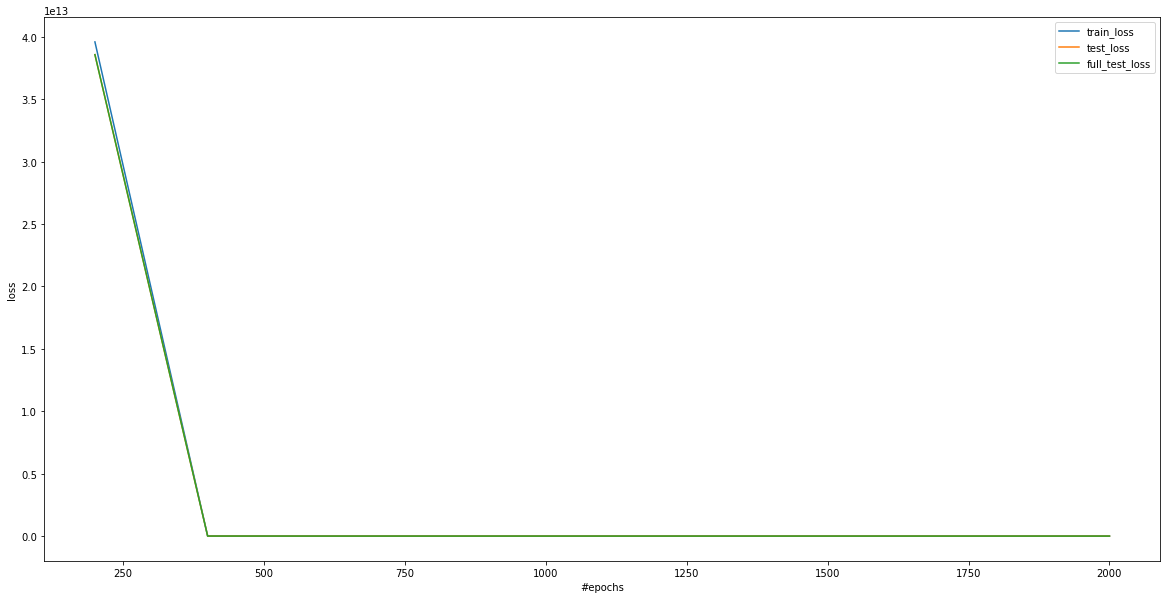

In [9]:
"""PLOT loss reduction during training.
"""
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(model_his_sgd.epoch, model_his_sgd.train_loss)
plt.plot(model_his_sgd.epoch, model_his_sgd.test_loss)
plt.plot(model_his_sgd.epoch, model_his_sgd.full_test_loss)
plt.legend(['train_loss', 'test_loss', 'full_test_loss'])
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.show()

We can see that training with small batches of random samples (mini-batch SGD), the trajectory of loss
values becomes a bit zig-zag in shape, but still follows the similar path as previously when
we train with full dataset. Also SGD make model converage faster! We just need 250 epochs to get a good result.

## Learning rate scheduling and gradients normalization

In [6]:
"""Apply gradient clipping and learning rate reduction.
"""
class GradientClipping(object):
    def __init__(self, lr=1e-2, clipnorm=None):
        self._lr = tf.Variable(lr, tf.float32)
        self.clipnorm = clipnorm

    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            if self.clipnorm: 
                grad = tf.clip_by_norm(grad, self.clipnorm)
            update = -1 * self._lr * grad
            var.assign_add(update)

In [31]:
"""Create new train fuction for applying optimizer.
"""
@tf.function
def training_step(model, x, y, optimizer):
    with tf.GradientTape(persistent=True) as tp:
        loss = tf.reduce_mean(tf.square(y - model(x)))
    gradients = tp.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
    return loss


@tf.function
def testing_step(model, x_test, y_test):
    return tf.reduce_mean(tf.square(y_test - model(x_test)))


def train(model, optimizer, epochs, learning_rate):
    optimizer.lr = learning_rate
    his = []
    for epoch in range(1, epochs+1):
        train_loss = []
        for x, y in train_ds:
            train_loss.append(training_step(model, x, y, optimizer).numpy())
        test_loss_batch = []
        for x, y in test_ds:
            test_loss_batch.append(testing_step(model, x, y).numpy())
        
        full_test_loss = testing_step(model, x_test, y_test)
            
        if not(epoch%10):
            his.append({'epoch': epoch,
                        'train_loss': np.mean(train_loss),
                        'test_loss': np.mean(test_loss_batch),
                        'full_test_loss': full_test_loss.numpy()
            })
            print('Epoch {} has mean squeared loss {}.'.format(epoch, np.mean(train_loss)))  
          
        # learning rate scheduler
        part = epochs//4
        schedul = 0
        if not(schedul % part):
            learning_rate/=2
        schedul += 1
            
    return model, pd.DataFrame(his)

In [8]:
model, model_his_GCLR = train(FCN(4, 1), GradientClipping(clipnorm=2), 100, 1e-2)

Epoch 10 has mean squeared loss 234.8991241455078.
Epoch 20 has mean squeared loss 168.8555450439453.
Epoch 30 has mean squeared loss 163.0618896484375.
Epoch 40 has mean squeared loss 137.60589599609375.
Epoch 50 has mean squeared loss 107.49442291259766.
Epoch 60 has mean squeared loss 79.55366516113281.
Epoch 70 has mean squeared loss 71.18053436279297.
Epoch 80 has mean squeared loss 72.12244415283203.
Epoch 90 has mean squeared loss 71.83207702636719.
Epoch 100 has mean squeared loss 71.83731842041016.


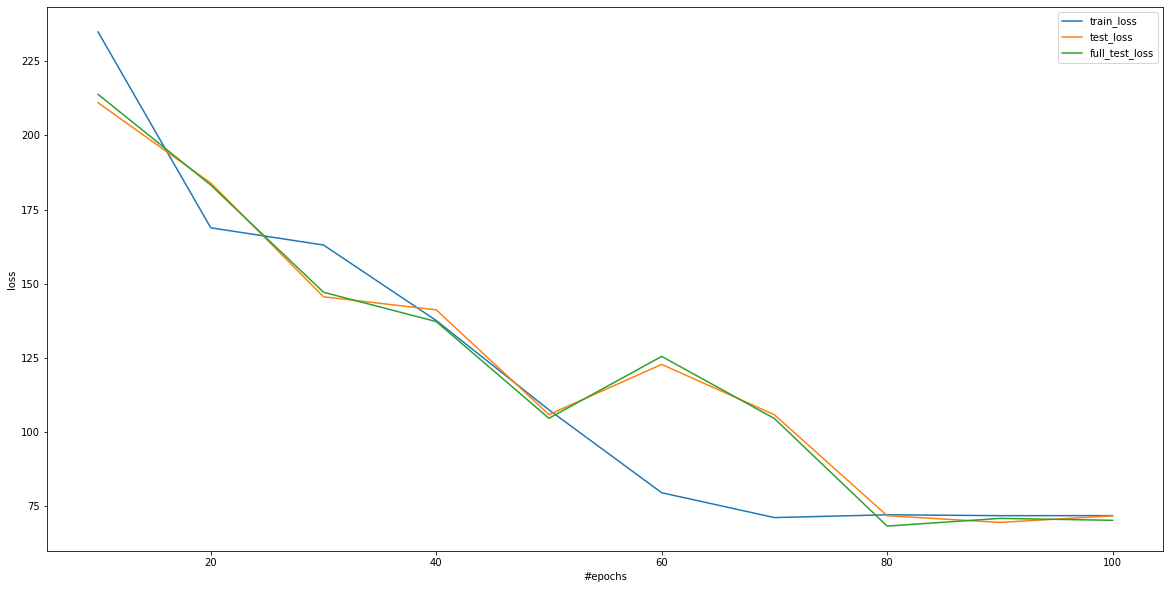

In [9]:
"""PLOT loss reduction during training.
"""
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(model_his_GCLR.epoch, model_his_GCLR.train_loss)
plt.plot(model_his_GCLR.epoch, model_his_GCLR.test_loss)
plt.plot(model_his_GCLR.epoch, model_his_GCLR.full_test_loss)
plt.legend(['train_loss', 'test_loss', 'full_test_loss'])
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.show()

Training model with SGD, learning rate scheduler and gradient clipping can make model has a good result in first 100 epochs.

# With mometum

In [7]:
class GClippingWMomentum(object):
    def __init__(self, lr=1e-2, beta=0.9, clipnorm=None):
        self._lr = tf.Variable(lr, tf.float32)
        self._beta = tf.Variable(beta, tf.float32) 
        self.clipnorm = clipnorm
        self._moments = None
    
    def init_moment(self, var_list):
        # Set moment and variant index for each parameter
        # Consuming memory space (= variables's space) to store all gradient history of variables (parameters)
        self._moments = {var._unique_id: tf.Variable(tf.zeros_like(var)) for var in var_list}
    
    def apply_gradients(self, grads_and_vars):
        for grad, var in (grads_and_vars):
            if self.clipnorm: 
                grad = tf.clip_by_norm(grad, self.clipnorm)
            moment = self._moments[var._unique_id]
            moment.assign(self._beta*moment - self._lr*grad)
            var.assign_add(moment)           

In [8]:
"""We have to decleare the initial momentum first.
Thus, we have to hand-craftly create the initial state of model.
"""
model = FCN(4, 1)
model.build((32, 13))

optimizer = GClippingWMomentum(beta=0.9, clipnorm=2)
optimizer.init_moment(model.variables)

model, model_his_GCLRMM = train(model, optimizer, 100, 1e-2)

Epoch 10 has mean squeared loss 89.61888885498047.
Epoch 20 has mean squeared loss 182.19834899902344.
Epoch 30 has mean squeared loss 99.21309661865234.
Epoch 40 has mean squeared loss 111.57193756103516.
Epoch 50 has mean squeared loss 130.2427520751953.
Epoch 60 has mean squeared loss 150.1815948486328.
Epoch 70 has mean squeared loss 95.29995727539062.
Epoch 80 has mean squeared loss 84.90880584716797.
Epoch 90 has mean squeared loss 84.20623779296875.
Epoch 100 has mean squeared loss 96.72494506835938.


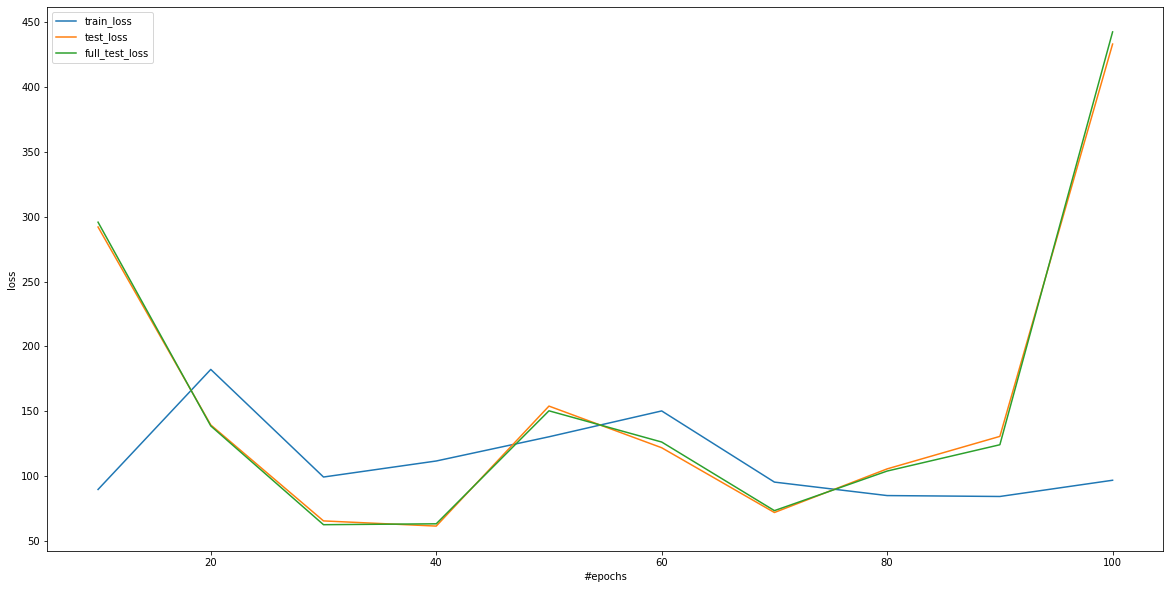

In [9]:
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(model_his_GCLRMM.epoch, model_his_GCLRMM.train_loss)
plt.plot(model_his_GCLRMM.epoch, model_his_GCLRMM.test_loss)
plt.plot(model_his_GCLRMM.epoch, model_his_GCLRMM.full_test_loss)
plt.legend(['train_loss', 'test_loss', 'full_test_loss'])
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.show()

The model converages faster than without momentum, but it seems like need to be stopped at 80th epoch. Due to meet the overfitting problem then.

## First moment / Second moment

The optimizer uses two sets of accumulators to keep track of the first two moments of the gradients. The algorithm uses the second moment to scale the first moment, intuitively this works like a signal to noise ratio adjustment, with the first moment be the signal and the second moment be noise. Since all the operations are elementwise, this signal to noise treatment is customized for each and every parameter in the model, so effectively every parameter has its own learning rate.

In [11]:
class Adam(object):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.99, epsi=1e-8, clipnorm=None):
        self._lr = lr
        self._beta1 = beta1
        self._beta2 = beta2
        self._epsi = epsi
        self.clipnorm = clipnorm
        self._t = tf.Variable(0.0, tf.float32)
    
    def init_moment(self, var_list):
        # Set moment and variant index for each parameter
        self._moments = {var._unique_id: tf.Variable(tf.zeros_like(var)) for var in var_list}
        self._variants = {var._unique_id: tf.Variable(tf.zeros_like(var)) for var in var_list}
        
    def apply_gradients(self, grads_and_vars):
        self._t.assign_add(tf.constant(1.0, self._t.dtype))
        for grad, var in grads_and_vars:
            #grad clip first
            if self.clipnorm: grad = tf.clip_by_norm(grad, self.clipnorm)
                
            # Set moment and variant for each parameter by set index    
            moments = self._moments[var._unique_id]
            variants = self._variants[var._unique_id]

            # Update 
            moments.assign(self._beta1 * moments + (1. - self._beta1) * grad)
            variants.assign(self._beta2 * variants + (1. - self._beta2) * tf.square(grad))
            # Apply bias correction to learning rate (or to moments/variants instead)
            # Bias correction helps moments and variants become bigger in the first updates.
            lr = self._lr * tf.sqrt(1 - tf.pow(self._beta2, self._t))/\
                                    (1 - tf.pow(self._beta1, self._t))

            update = -lr * moments/(tf.sqrt(variants) + self._epsi)

            var.assign_add(update)

In [12]:
model = FCN(4, 1)
model.build((32, 13))

optimizer = Adam(clipnorm=2)
optimizer.init_moment(model.variables)

model, model_his_Adam = train(model, optimizer, 100, 1e-2)

Epoch 10 has mean squeared loss 53.4597282409668.
Epoch 20 has mean squeared loss 46.92344665527344.
Epoch 30 has mean squeared loss 42.947052001953125.
Epoch 40 has mean squeared loss 56.753421783447266.
Epoch 50 has mean squeared loss 53.07309341430664.
Epoch 60 has mean squeared loss 40.502986907958984.
Epoch 70 has mean squeared loss 36.484378814697266.
Epoch 80 has mean squeared loss 35.27321243286133.
Epoch 90 has mean squeared loss 30.10268211364746.
Epoch 100 has mean squeared loss 32.57645034790039.


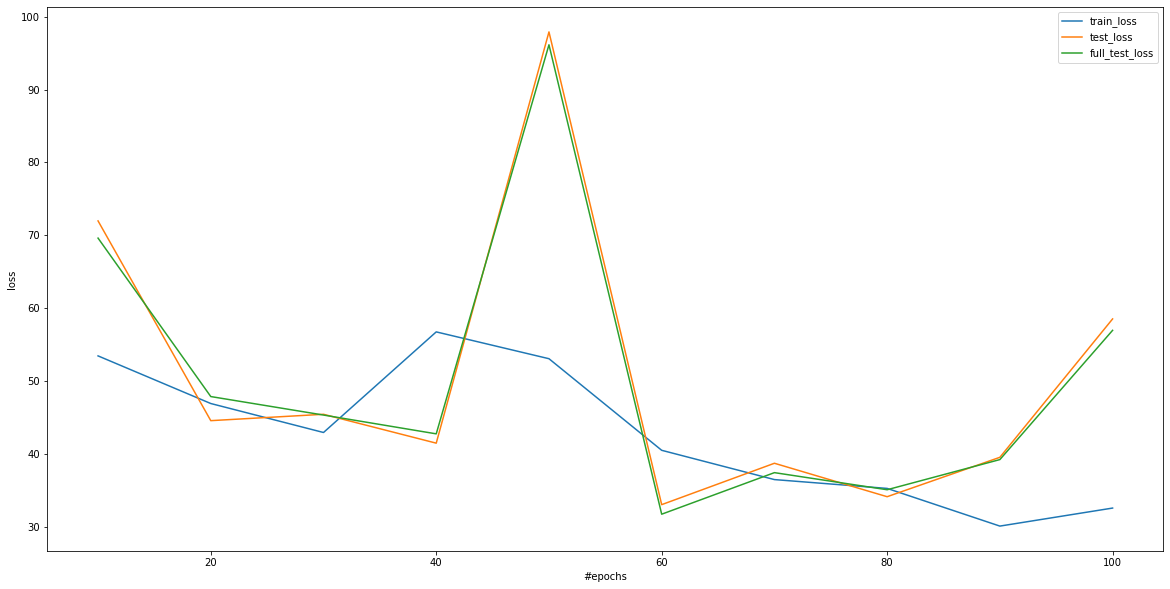

In [13]:
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(model_his_Adam.epoch, model_his_Adam.train_loss)
plt.plot(model_his_Adam.epoch, model_his_Adam.test_loss)
plt.plot(model_his_Adam.epoch, model_his_Adam.full_test_loss)
plt.legend(['train_loss', 'test_loss', 'full_test_loss'])
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.show()

Look at the plot, we have archived the new record of training/testing loss. 

From now on, you can just use *tf.keras.optimizers.Adam* whenever training a model.
